In [1]:
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

2023-12-07 15:18:10.477739: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 15:18:10.526873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 15:18:11.422150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

In [3]:
# Load integrated scene
# scene = load_scene("./Single Box/Single Box.xml") # Try also sionna.rt.scene.etoile
scene = load_scene(sionna.rt.scene.munich) # Try also sionna.rt.scene.etoile

2023-12-07 15:18:17.438204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18874 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:4f:00.0, compute capability: 8.6


In [4]:
scene.preview(show_orientations=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [5]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")



# Add transmitter instance to scene
tx_object = scene.get("tx")
if tx_object is not None:
    scene.remove("tx")
# Create transmitter
tx = Transmitter(name="tx",
                 position=[8.5,21,27])
scene.add(tx)

rx_object = scene.get("rx")
if rx_object is not None:
    scene.remove("rx")
rx = Receiver(name="rx",
              position=[45,90,1.5],
              orientation=[0,0,0])
scene.add(rx)
tx.look_at(rx)


In [6]:
scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [7]:
paths = scene.compute_paths(max_depth=3,num_samples=1e6,los=True,reflection=True,scattering=True,diffraction=True)
paths.normalize_delays = False

In [8]:
a, tau = paths.cir()
print("Shape of tau: ", tau.shape)

Shape of tau:  (1, 1, 1, 230)


In [9]:
subcarrier_spacing = 15e3
fft_size = 1024
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)

# Compute the frequency response of the channel at frequencies.
h_freq = cir_to_ofdm_channel(frequencies,
                             a,
                             tau,
                             normalize=True) # Non-normalized includes path-loss
# h_freq = tf.expand_dims(h_freq, axis=-1) # Add batch dimensionh
h_freq

<tf.Tensor: shape=(1, 1, 1, 1, 1, 1, 1024), dtype=complex64, numpy=
array([[[[[[[ 0.71242523-0.36586252j,  0.7046738 -0.3821878j ,
              0.6965312 -0.3983169j , ..., -0.31752223-0.5198255j ,
             -0.3173406 -0.5084335j , -0.31679443-0.49793088j]]]]]]],
      dtype=complex64)>

In [32]:
# Placeholder for tx signal of shape
# [batch size, num_tx, num_tx_ant, num_ofdm_symbols, fft_size]
x = tf.zeros([h_freq.shape.as_list()[i] for i in [0,3,4,5,6]], tf.complex64)

no = 0.1 # noise variance

# Init channel layer
channel = ApplyOFDMChannel(add_awgn=True)

# Apply channel
y = channel([x, h_freq, no])
# [batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size]

y = y*x
y = tf.expand_dims(y, axis=-1)
y_H = tf.math.conj(tf.transpose(y, perm=[0,1,2,3,5,4]))
y_conv = tf.matmul(y, y_H)
y_conv

<tf.Tensor: shape=(1, 1, 1, 1, 1024, 1024), dtype=complex64, numpy=
array([[[[[[ 0.+0.j, -0.+0.j, -0.+0.j, ...,  0.+0.j,  0.+0.j,
             0.+0.j],
           [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,
             0.+0.j],
           [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,
             0.+0.j],
           ...,
           [ 0.+0.j, -0.+0.j, -0.+0.j, ...,  0.+0.j,  0.+0.j,
             0.+0.j],
           [ 0.+0.j, -0.+0.j, -0.+0.j, ...,  0.+0.j,  0.+0.j,
             0.+0.j],
           [ 0.+0.j, -0.+0.j, -0.+0.j, ...,  0.+0.j,  0.+0.j,
             0.+0.j]]]]]], dtype=complex64)>

In [10]:
h= tf.expand_dims(h_freq, axis=-1)
h_H = tf.math.conj(tf.transpose(h, perm=[0,1,2,3,4,5,7,6]))
h_conv = tf.matmul(h, h_H)
h_conv = tf.squeeze(h_conv)
h_conv.shape

TensorShape([1024, 1024])

In [11]:
eig_vals, eig_vecs = tf.linalg.eigh(h_conv)
# eig_vals = tf.abs(eig_vals)
# sorted_index = tf.argsort(eig_vals, axis=-1, direction='DESCENDING')
# eig_vecs = tf.gather(eig_vecs, sorted_index, axis=-1)
eig_vals = tf.squeeze(eig_vals)
eig_vecs = tf.squeeze(eig_vecs)

2023-12-07 15:19:41.269732: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x18e0f00


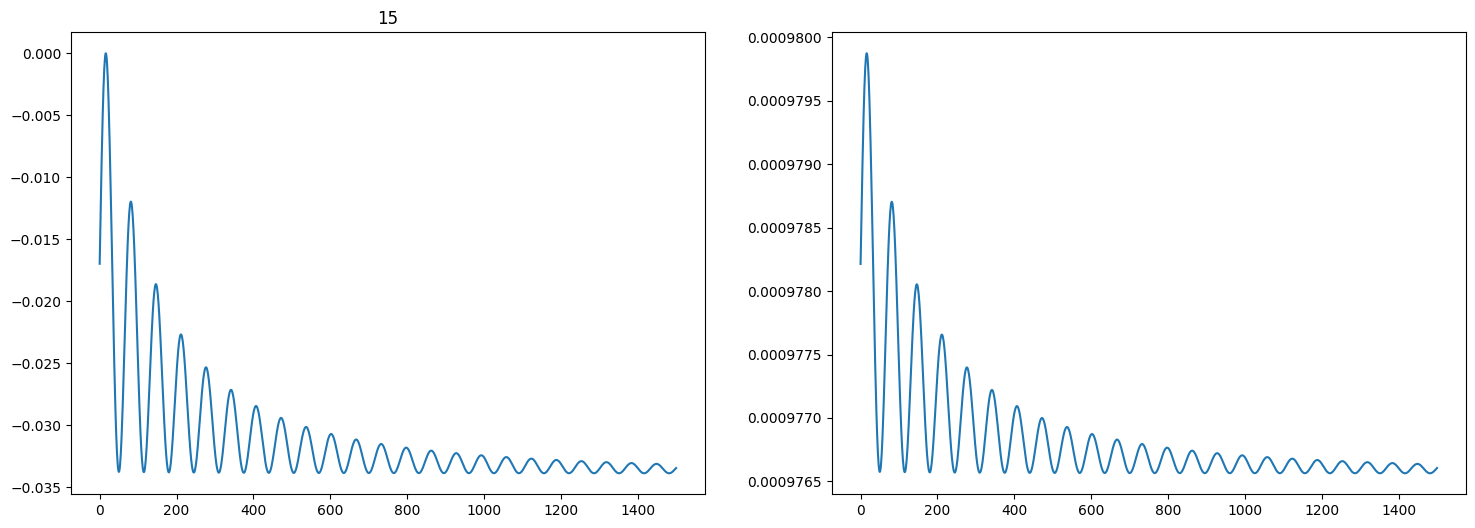

In [13]:
tau_range = np.arange(0, 1500, 1)
frequencies = tf.cast(frequencies, dtype=tf.complex64)
# 初始化 TensorArray 以存储结果
P_tau_array = tf.TensorArray(dtype=tf.complex64, size=len(tau_range))

for idx in range(len(tau_range)):
    a_m = tf.expand_dims(tf.math.exp(-1j * 2 * np.pi * frequencies * (tau_range[idx]/1e9)), axis=0)
    G_n = tf.cast(eig_vecs[:,:-1], dtype=tf.complex64)
    G_n_H = tf.math.conj(tf.transpose(G_n))
    a_m_H = tf.math.conj(tf.transpose(a_m))
    P_tau_array = P_tau_array.write(idx, 1 / (a_m @ G_n @ G_n_H @ a_m_H))

# 将 TensorArray 转换为常规 Tensor
P_tau = P_tau_array.stack()
# 计算谱函数
P_tau_real, P_tau_imag = tf.math.real(P_tau), tf.math.imag(P_tau)
P_abs = tf.math.sqrt(P_tau_real**2 + P_tau_imag**2)
P_norm = 10 * tf.math.log(P_abs / tf.reduce_max(P_abs), 10)
P_norm = tf.squeeze(P_norm)
max_idx = tf.argmax(P_norm)
# 绘制
# 调整画布大小
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(tau_range, tf.squeeze(P_norm))
# plt.scatter(tau_range[max_idx], P_norm[max_idx], c='r')
plt.title(f"{max_idx-1}")
plt.subplot(1, 2, 2)
plt.plot(tau_range, tf.squeeze(P_abs))
    

In [36]:
tau*1e9

<tf.Tensor: shape=(1, 1, 1, 10), dtype=float32, numpy=
array([[[[ 273.91888,  277.18958,  732.6985 , 1029.7968 ,  592.75885,
           523.95856,  675.1701 ,  733.9275 , 1030.6715 , 1159.6471 ]]]],
      dtype=float32)>

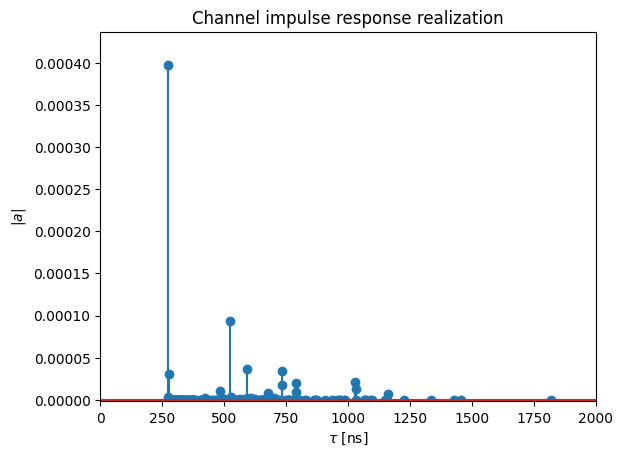

In [14]:
a, tau = paths.cir()
t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

In [38]:
# CRB 1
snr = 10
H=a[0,0,0,0,0,:,0]
H=H[H!=0]
H_H = np.conj(H)
l = len(H)
B = tf.reshape(H_H, [l,1]) @ tf.reshape(H, [1,l])
B_inv = tf.linalg.inv(B)
B_diag = tf.linalg.diag_part(B_inv)
crb1 = tf.abs(tf.cast(B_diag,tf.complex128)) / tf.cast((8 * np.pi**2 * snr * scene.frequency**2),tf.float64)

In [39]:
#CRB 2
snr = 1
alpha=paths.a[0,0,0,0,0,:,0]
tau=paths.tau[0,0,0,:]
tau=tau[alpha!=0]
alpha=alpha[alpha!=0]
length = len(alpha)
tau_i = tf.repeat(tau,length)
tau_i = tf.reshape(tau_i, (length,length))
tau_j = tf.transpose(tau_i)
tau_i_mine_j = tau_i- tau_j
tau_i_mul_j = tau_i* tau_j
alpha_ij = tf.reshape(alpha, (length,1)) @ tf.reshape(alpha, (1,length))
one = tf.ones((length,length))
F_alpha= 2*snr*tf.math.abs(alpha_ij)/(tau_i_mul_j**2)
F_cos = (one+4*(np.pi**2)*(scene.frequency**2) * tau_i_mul_j)*tf.math.cos(2*np.pi*scene.frequency*tau_i_mine_j)
F_sin = 2*np.pi*scene.frequency*tau_i_mine_j*tf.math.sin(2*np.pi*scene.frequency*tau_i_mine_j)
F = F_alpha*(F_cos+F_sin)
crb_F = tf.linalg.inv(F)
crb2 = tf.linalg.diag_part(crb_F)

In [40]:
#CRB 3
snr = 1
H=a[0,0,0,0,0,:,0]
tau=paths.tau[0,0,0,:]
tau = tau[H!=0]
H = H[H!=0]
H_H = np.conj(H)
l = len(H)
length = len(H)
tau_i = tf.repeat(tau,length)
tau_i = tf.reshape(tau_i, (length,length))
tau_j = tf.transpose(tau_i)
tau_i_mine_j = tau_i- tau_j
tau_i_mul_j = tau_i* tau_j
B_1 = tf.reshape(H_H, [l,1]) @ tf.reshape(H, [1,l])
one = tf.ones((length,length))
real = one + 4*(np.pi**2)*(scene.frequency**2) * tau_i_mul_j
img = 2*np.pi*scene.frequency*tau_i_mine_j
B_2 = tf.complex(real, img)
B_total = tf.abs(B_1*B_2)
B_total = B_total/tau_i_mul_j**2
crb3 = tf.linalg.diag_part(tf.linalg.inv(tf.abs(B_total)))

In [41]:
scene.preview(paths=paths,show_paths=True,show_orientations=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

In [42]:
#CRB 2 float64
snr = 1
pi = tf.constant(np.pi, dtype=tf.float64)
alpha=paths.a[0,0,0,0,0,:,0]
tau=paths.tau[0,0,0,:]
length = len(alpha)
tau_i = tf.repeat(tau,length)
tau_i = tf.reshape(tau_i, (length,length))
tau_j = tf.transpose(tau_i)
tau_i_mine_j = tf.cast(tau_i,tf.float64) - tf.cast(tau_j,tf.float64)
tau_i_mul_j = tf.cast(tau_i,tf.float64) * tf.cast(tau_j,tf.float64)
alpha_ij = tf.reshape(alpha, (length,1)) @ tf.reshape(alpha, (1,length))
alpha_ij = tf.cast(alpha_ij,tf.float64)
one = tf.cast(tf.ones((length,length)),tf.float64)
F_alpha= 2*snr*tf.math.abs(alpha_ij)/(tau_i_mul_j**2)
F_cos = (one+(tf.cast(4*(np.pi**2)*(scene.frequency**2),tf.float64) * tau_i_mul_j))*tf.math.cos(tf.cast(2*np.pi*scene.frequency,tf.float64)*tau_i_mine_j)
F_sin = tf.cast(2*np.pi*scene.frequency,tf.float64)*tau_i_mine_j*tf.math.sin(tf.cast(2*np.pi*scene.frequency,tf.float64)*tau_i_mine_j)
F = F_alpha*(F_cos+F_sin)
crb_F = tf.linalg.inv(F)
crb2 = tf.linalg.diag_part(crb_F)

In [43]:
#CRB 3 float64
snr = 1
H=a[0,0,0,0,0,:,0]
H_H = np.conj(H)
l = len(H)
tau=paths.tau[0,0,0,:]
length = len(alpha)
tau_i = tf.repeat(tau,length)
tau_i = tf.reshape(tau_i, (length,length))
tau_j = tf.transpose(tau_i)
tau_i_mine_j = tf.cast(tau_i,tf.float64) - tf.cast(tau_j,tf.float64)
tau_i_mul_j = tf.cast(tau_i,tf.float64) * tf.cast(tau_j,tf.float64)
B_1 = tf.reshape(H_H, [l,1]) @ tf.reshape(H, [1,l])
one = tf.cast(tf.ones((length,length)),tf.float64)
real = one + tf.cast(4*(np.pi**2)*(scene.frequency**2),tf.float64) * tau_i_mul_j
img = tf.cast(2*np.pi*scene.frequency,tf.float64)*tau_i_mine_j
B_2 = tf.complex(real, img)
B_1 = tf.cast(B_1,tf.complex128)
B_2 = tf.cast(B_2,tf.complex128)
B_total = tf.abs(B_1*B_2)
B_total = tf.cast(B_total,tf.float64)
B_total = B_total/tau_i_mul_j**2
crb3 = tf.linalg.diag_part(tf.linalg.inv(tf.abs(B_total)))

In [44]:
phi_r = paths.phi_r[0,0,0,:]
phi_t = paths.phi_t[0,0,0,:]
theta_r = paths.theta_r[0,0,0,:]
theta_t = paths.theta_t[0,0,0,:]
print("phi_r: ", phi_r)
print("phi_t: ", phi_t)
print("theta_r: ", theta_r)
print("theta_t: ", theta_t)

phi_r:  tf.Tensor(
[-2.0573626  -2.0573626   0.53683597 -1.92602    -0.7590694   1.3314312
  1.6831499   0.5368359  -1.9260199  -2.143458  ], shape=(10,), dtype=float32)
phi_t:  tf.Tensor(
[1.0842302  1.0842302  0.51573205 1.2044787  0.14485087 1.1662083
 2.0694542  0.51573205 1.2044786  1.8748856 ], shape=(10,), dtype=float32)
theta_r:  tf.Tensor(
[1.2550503 1.9208661 1.4544442 1.4881043 1.4268028 1.4077358 1.7120686
 1.7006916 1.6631644 1.4973814], shape=(10,), dtype=float32)
theta_t:  tf.Tensor(
[1.8865423 1.9208658 1.6871486 1.6534884 1.71479   1.7338569 1.7120686
 1.7006916 1.6631645 1.6442113], shape=(10,), dtype=float32)
